# Report

## DQN

In a Deep Q Network (DQN), the target Q value is computed as
$
\begin{align}
y = r + \gamma \mathrm{max}_{a'} Q_{\theta'} (s', a')
\end{align}
$
where $r$ is the immediate reward and $\gamma$ is the discount factor.

## DDQN

In a Double DQN (DDQN), two networks are used to solve the problem of overestimating the Q function resulting out of the `max` function in choosing the optimal action. The main Q network,  parametrized by $\theta$, is used for selecting the maximum Q value, and the target Q network, parametrized by $\theta'$, computes the Q value from the action selected by the main network:

$
\begin{equation}
y = r + \gamma Q_{\theta'}  ( s', \mathrm{argmax}_{a'} Q_\theta (s', a')  )
\end{equation}
$


## Prioritized Experience Replay

Transitions from the replay buffer can be sampled based on their priority as not all $(s, a, s', r)$ transitions are of equal priority. The priority of a transition is assigned the absolute value of the error the learning network makes, plus a small value $\epsilon$ to include transitions that may not have any error value:

$
\begin{equation}
p_i = |\delta_i| + \epsilon
\end{equation}
$

The priority is converted into a probability of transition
$
\begin{equation}
P(i) = \frac{p_i}{\sum_k p_k}
\end{equation}
$

The amount of prioritization is controlled by a hyperparameter $\alpha$

$
\begin{equation}
P(i) = \frac{p_i^\alpha}{\sum_k p_k^\alpha}
\end{equation}
$

where $0 \le \alpha \le 1$ and $\alpha=0$ recovers a random sampling from the replay buffer.

To prevent a learning that overfits on the highly prioritized transitions, another hyperparameter $\beta$ is used to control the number of occurrence of the highly prioritized transitions. It is done by assigning a weight $w_i$ to the $i$-th transition

$
\begin{equation}
w_i = \left ( \frac{1}{N P(i)} \right )^\beta
\end{equation}
$


## Network

The ANN used for both the main and target Q networks consisted of the following layers:
* Input layer of size 37, corresponding to the number of states in the environment
* Fully connected layer of size 256, followed by ReLu actication
* Fully connected layer of size 256, followed by ReLu actication
* Fully connected layer of size 256, followed by ReLu actication
* Output layer of size 4, correspnding to the size of the action space



## Configurations

The various parameters are defined in the `banana_config.py` file.

| parameter | description |
|---: | :---|
| `eps_start` | starting value of epsilon (epsilon greedy policy)|
| `eps_end` | maximum value of epsilon |
| `eps_decay` | rate of epsilon decay |
| `lr` | learning rate in loss optimizer for Q-network|
| `update_every` | how often the target network is updated |
| `batch_size` | batch size for ANN training |
| `beta` | importance weight exponent |
| `alpha` | prioritization exponent |
| `gamma` | discount factor in the Bellman equation |
| `tau` | parameter to control amount of copy from main to target network parameters | 
| `max_time_in_episode` | the maximum number of steps to run in an episode during training|
| `num_nodes` | number of nodes used in the hidden ANN layers|


## Experiments

The experiments included using the DDQN with the following hyprerparameter combinations:
|network|memory access|$\alpha$|$\beta$|
|--|--|--|--|
|DDQN|Random|||
|DDQN|Priority|0.5|0.4|
|DDQN|Priority|0.5|0.8|
|DDQN|Priority|0.1|0.4|
|DDQN|Priority|0.7|0.4|
|DDQN|Priority|0.9|0.2|


## Performance

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
run01 = pd.read_csv("run_prio_0.1.csv")
run05 = pd.read_csv("run_prio_0.5.csv")
run05_beta08 = pd.read_csv("run_prio_0.5_beta_0.8.csv")
run05_alpha09_beta02 = pd.read_csv("run_prio_0.9_beta_0.2.csv")
run07 = pd.read_csv("run_prio_0.7.csv")
run_random = pd.read_csv("run_random.csv")
dqn_alpha09_beta02 = pd.read_csv("dqn_prio_0.9_beta_0.2.csv")

df = pd.concat([run01, run05, run05_beta08, run05_alpha09_beta02, run07, run_random, dqn_alpha09_beta02], axis=1)
df.columns=["prio_0.1", "prio_0.5", "prio_0.5_beta_0.8", "alpha09_beta02", "prio_0.7", "random", "DQN"]
df

,prio_0.1,prio_0.5,prio_0.5_beta_0.8,alpha09_beta02,prio_0.7,random,DQN
0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
1,0.0,2.0,2.0,2.0,2.0,3.0,2.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0
3,0.0,0.0,0.0,0.0,0.0,-3.0,0.0
4,0.0,-1.0,0.0,-1.0,0.0,-2.0,-2.0
...,...,...,...,...,...,...,...
995,7.0,16.0,12.0,12.0,15.0,16.0,19.0
996,17.0,11.0,16.0,14.0,13.0,23.0,19.0
997,21.0,13.0,16.0,8.0,17.0,18.0,20.0
998,15.0,10.0,12.0,15.0,10.0,9.0,22.0


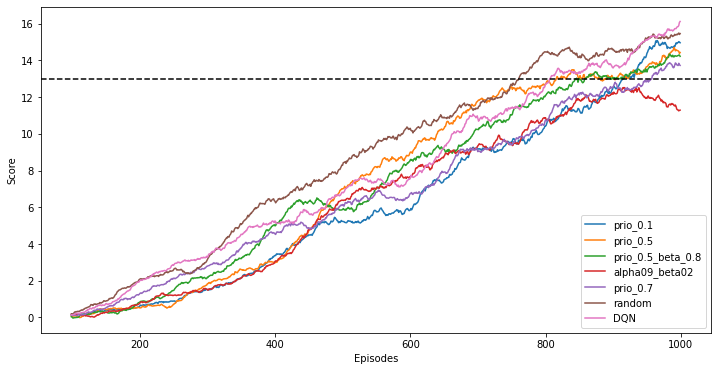

In [4]:
_, ax = plt.subplots(1, 1, figsize=[12, 6])
df.rolling(100).mean().plot(ax=ax)
ax.set_xlabel("Episodes")
ax.set_ylabel("Score")
ax.axhline(y=13, ls="--", c="k");

## Further Improvements

It is interesting to see that the random access of buffer performs better than the priority access. Therefore, further optimization of $\alpha$ ans $\beta$ are unlikely to yield much success. Therefore, one important future improvement could be to experiment with the dueling DQN.

It was observed that the agent could occasionally get stuck at certain states when it thrashes between two actions without making any progress. Further investigation is necessary to understand the root cause of such edge cases and retrain the agent to handle these states.